In [18]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit
import pickle

---

# KPIs

## Utilization / Peak Utilization (Anne)

The first KPI we want to consider is Utilization. We compute the amount of utilized bicycles to the total amount of bicycles in our fleet on an hourly basis. 

### Marburg

The first city to consider is Marburg. We import the data and round the start time of each of the trips down to the full hour. For simplicity, trips that are longer than an hour are only counted in the first hour. This should be considered when looking at the results later. We now have the following data frame to work with:

In [19]:
#Read in data
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
fleet_size = len(marburg["b_number"].unique())
marburg
kpi_mar = pd.DataFrame()

#setting start and end date of the trips (start is rounded down hourly)
marburg["start"] = marburg.index.floor(freq = "H")
marburg['end'] = marburg.index + pd.to_timedelta(marburg['trip_duration_mins'], unit='m')
marburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,2019-07-04 13:00:00,2019-07-04 14:10:00
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2019-07-06 16:00:00,2019-07-06 17:12:00
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,2019-07-06 17:00:00,2019-07-06 18:19:00
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,2019-07-06 20:00:00,2019-07-06 20:41:00
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,2019-07-07 08:00:00,2019-07-07 08:59:00
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19 12:57:00,2019-05-19,12:57:00,91116,marburg,"(50.8279, 8.7751)","(50.8137, 8.7707)",6,12,20,2019-05-19 12:00:00,2019-05-19 13:17:00
2019-05-19 21:41:00,2019-05-19,21:41:00,91116,marburg,"(50.8137, 8.7707)","(50.8229, 8.7747)",6,21,7,2019-05-19 21:00:00,2019-05-19 21:48:00
2019-05-20 06:56:00,2019-05-20,06:56:00,91116,marburg,"(50.8229, 8.7747)","(50.82, 8.7737)",0,6,3,2019-05-20 06:00:00,2019-05-20 06:59:00


Now we compute utilization and plot it over the whole year. For better visualisation we resample by week:

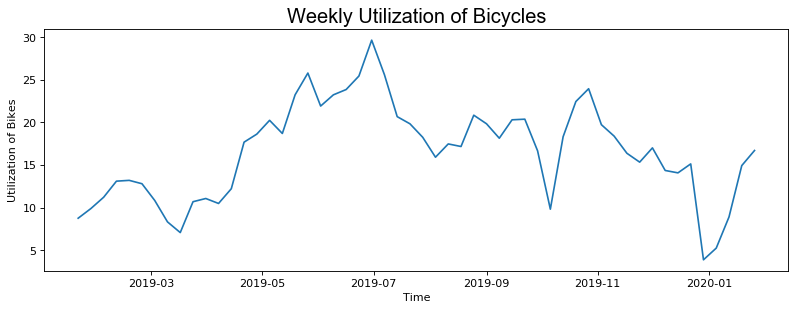

In [20]:
#computing availablility by grouping by datetime and checking the number of different bicycle numbers
kpi_mar["util"]  = marburg.groupby("start")["b_number"].nunique()

#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_mar["util"].resample("w").mean())
ax.set_title("Weekly Utilization of Bicycles", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bikes")
plt.show()

Because we want to compare two cities of different sizes we now change our utilization KPI from absolute numbers to percentages.

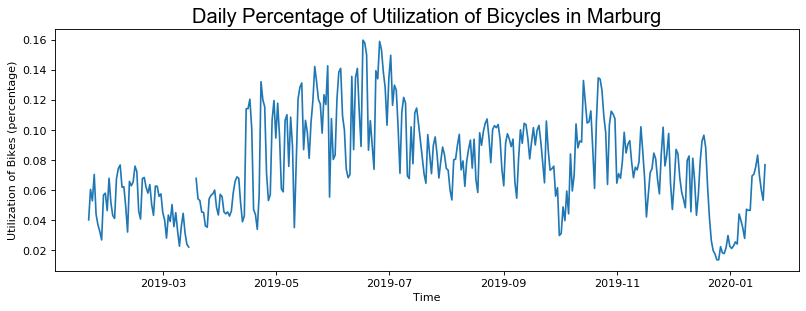

In [21]:
kpi_mar["util_percentage"]=kpi_mar["util"]/fleet_size

fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_mar["util_percentage"].resample("d").mean())
ax.set_title("Daily Percentage of Utilization of Bicycles in Marburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bikes (percentage)")
plt.show()

It can also be helpful to take a look at peek utilization. Therfore, we now compute the maximum utilization for each day in both absolute and realtive measures.

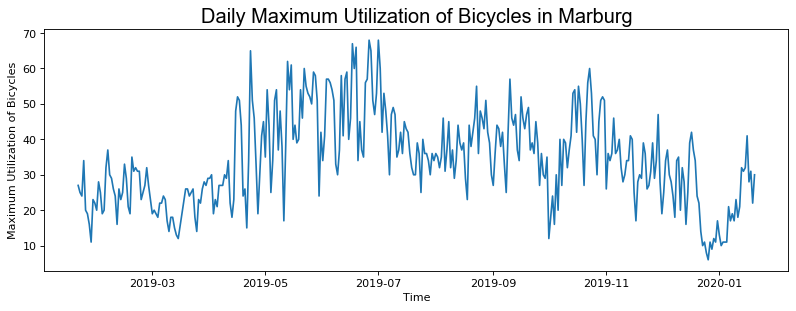

In [22]:
#creating day column
kpi_mar["date"] = kpi_mar.index.date

#computing max availaibility per day and plotting it
max_avail = kpi_mar.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Daily Maximum Utilization of Bicycles in Marburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Maximum Utilization of Bicycles")
plt.show()

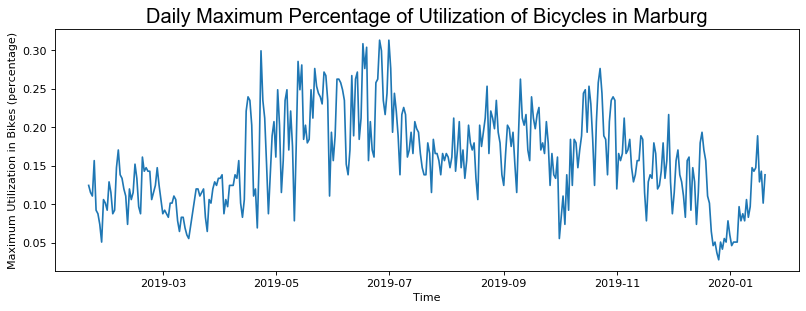

In [23]:
max_avail_percentage_mar = kpi_mar.groupby("date")["util_percentage"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail_percentage_mar)
ax.set_title("Daily Maximum Percentage of Utilization of Bicycles in Marburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Maximum Utilization in Bikes (percentage)")
plt.show()

Lastly, we are also interested in Utilization by Hour and by Weekday. This is computed and displayed in the following section.

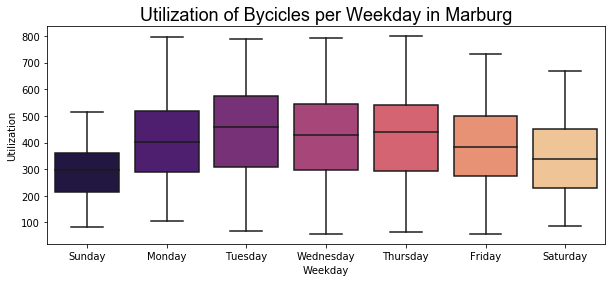

In [24]:
#Creating weekday and hour columns
def weekday_match (ts):
    return ts.weekday()

def hour_match (ts):
    return ts.hour

kpi_mar["weekday"]=kpi_mar.index.map(weekday_match)
kpi_mar["hour"]=kpi_mar.index.map(hour_match)
kpi_mar

day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
kpi_mar['weekday'] = kpi_mar['weekday'].map(day_of_week)

# Availability by day of week (0 = Monday, 6 = Sunday)

kpi_mar_weekday_util = kpi_mar.groupby(["date","weekday"])["util"].sum()
kpi_mar_weekday_util = pd.DataFrame(kpi_mar_weekday_util)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=kpi_mar_weekday_util.index.get_level_values(1), y=kpi_mar_weekday_util["util"],ax=ax, palette="magma")
ax.set_title("Utilization of Bycicles per Weekday in Marburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_xlabel("Weekday")
ax.set_ylabel("Utilization")
plt.show()

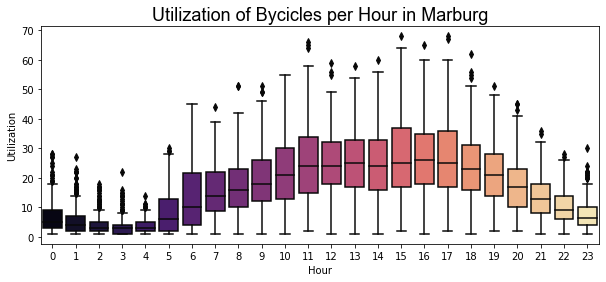

In [25]:
# Availability by time of day

kpi_mar_time_util = kpi_mar.groupby(["date","hour"])["util"].sum()
kpi_mar_time_util = pd.DataFrame(kpi_mar_time_util)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=kpi_mar_time_util.index.get_level_values(1), y=kpi_mar_time_util["util"],ax=ax, palette="magma")
ax.set_title("Utilization of Bycicles per Hour in Marburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Hour")
ax.set_ylabel("Utilization")
plt.show()

#plt.savefig("KPI_Util_Hour_Marburg.pdf")

### Duisburg

Next, we plot the same graphs for Duisburg. After importing and some preliminary work, we have the following table to work with:

In [26]:
#Read in data
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
fleet_size = len(duisburg["b_number"].unique())
duisburg
kpi_duis = pd.DataFrame()

#setting start and end date of the trips (start is rounded down hourly)
duisburg["start"] = duisburg.index.floor(freq = "H")
duisburg['end'] = duisburg.index + pd.to_timedelta(duisburg['trip_duration_mins'], unit='m')
duisburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,start,end
datetime,,,,,,,,,,,
2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,2019-05-27 14:00:00,2019-05-27 16:01:00
2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,2019-05-27 17:00:00,2019-05-27 18:04:00
2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,2019-05-28 08:00:00,2019-05-28 08:25:00
2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,2019-06-04 09:00:00,2019-06-04 09:25:00
2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,2019-06-05 09:00:00,2019-06-05 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 07:14:00,2020-01-20,07:14:00,501597,duisburg,"(51.4273, 6.7978)","(51.4294, 6.7772)",0,7,21,2020-01-20 07:00:00,2020-01-20 07:35:00
2020-01-20 10:08:00,2020-01-20,10:08:00,501597,duisburg,"(51.4294, 6.7772)","(51.4284, 6.8004)",0,10,10,2020-01-20 10:00:00,2020-01-20 10:18:00
2020-01-20 19:39:00,2020-01-20,19:39:00,501597,duisburg,"(51.4284, 6.8004)","(51.4294, 6.7772)",0,19,11,2020-01-20 19:00:00,2020-01-20 19:50:00


We now ,once again, compute absolute and relative utilization.

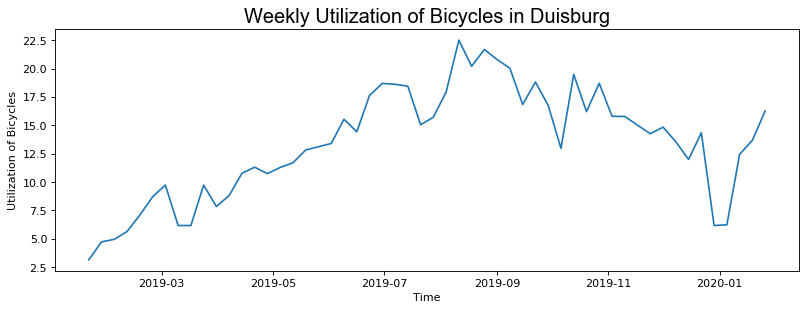

In [27]:
#computing availablility by grouping by datetime and checking the number of diiferent bike numbers
kpi_duis["util"]  = duisburg.groupby("start")["b_number"].nunique()


#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_duis["util"].resample("w").mean())
ax.set_title("Weekly Utilization of Bicycles in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()

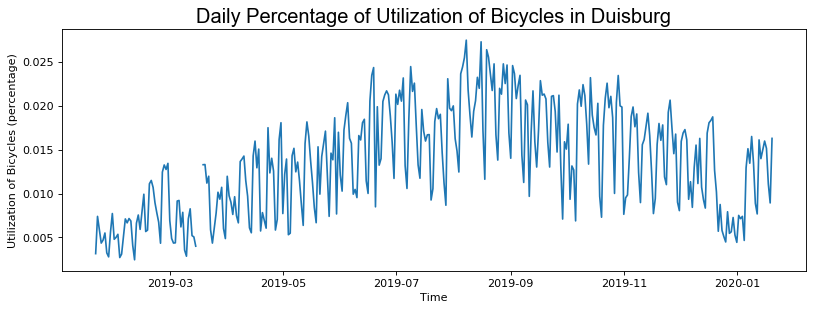

In [28]:
kpi_duis["util_percentage"]=kpi_duis["util"]/fleet_size

fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_duis["util_percentage"].resample("d").mean())
ax.set_title("Daily Percentage of Utilization of Bicycles in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles (percentage)")
plt.show()


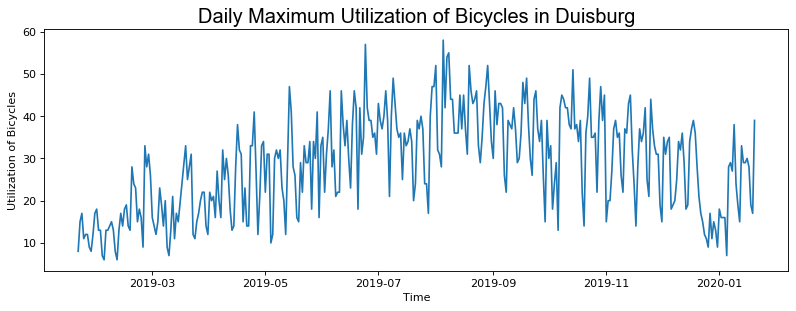

In [29]:
#creating day column
kpi_duis["date"] = kpi_duis.index.date

#computing max availaibility per day and plotting it
max_avail = kpi_duis.groupby("date")["util"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Daily Maximum Utilization of Bicycles in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()

Next, we calculate the peak utilization per day.

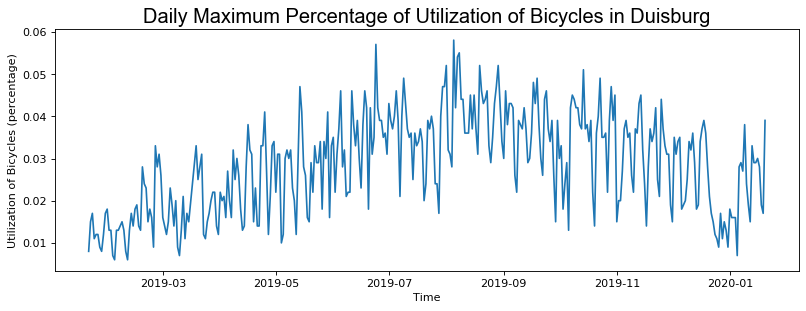

In [30]:
#computing max availaibility per day and plotting it
max_avail_percentage_duis = kpi_duis.groupby("date")["util_percentage"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail_percentage_duis )
ax.set_title("Daily Maximum Percentage of Utilization of Bicycles in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles (percentage)")
plt.show()


In the last part we also caclulate utilization by hour and weekday for Duisburg.

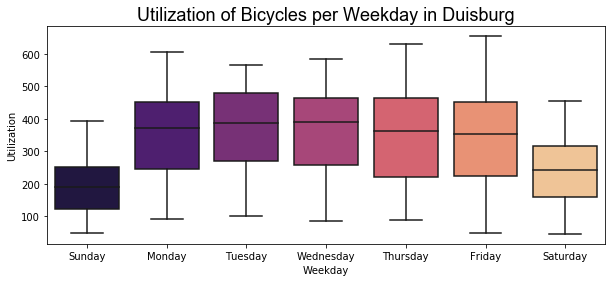

In [31]:
kpi_duis["weekday"]=kpi_duis.index.map(weekday_match)
kpi_duis["hour"]=kpi_duis.index.map(hour_match)
kpi_duis['weekday'] = kpi_duis['weekday'].map(day_of_week)
kpi_duis

# Availability by day of week (0 = Monday, 6 = Sunday)

kpi_duis_weekday_util = kpi_duis.groupby(["date","weekday"])["util"].sum()
kpi_duis_weekday_util = pd.DataFrame(kpi_duis_weekday_util)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=kpi_duis_weekday_util.index.get_level_values(1), y=kpi_duis_weekday_util["util"],ax=ax, palette="magma")
ax.set_title("Utilization of Bicycles per Weekday in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Weekday")
ax.set_ylabel("Utilization")
plt.show()


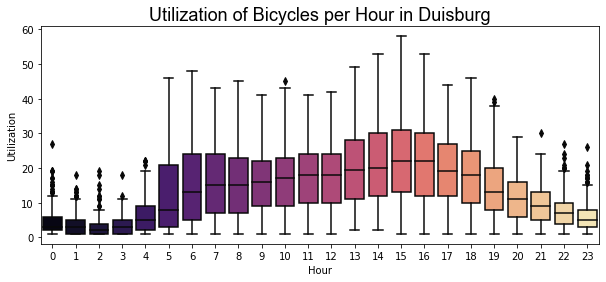

In [32]:
# Availability by time of day

kpi_duis_time_util = kpi_duis.groupby(["date","hour"])["util"].sum()
kpi_duis_time_util = pd.DataFrame(kpi_duis_time_util)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=kpi_duis_time_util.index.get_level_values(1), y=kpi_duis_time_util["util"],ax=ax, palette="magma")
ax.set_title("Utilization of Bicycles per Hour in Duisburg", fontsize=18, fontname="Arial")
ax.set_xlabel("Hour")
ax.set_ylabel("Utilization")
plt.show()

### Comparison of both cities

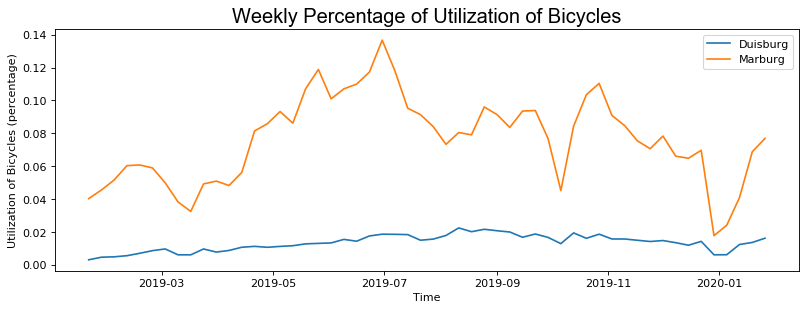

In [37]:
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi_duis["util_percentage"].resample("w").mean())
ax.plot(kpi_mar["util_percentage"].resample("w").mean())
ax.set_title("Weekly Percentage of Utilization of Bicycles", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles (percentage)")
ax.legend(["Duisburg", "Marburg"])
plt.show()

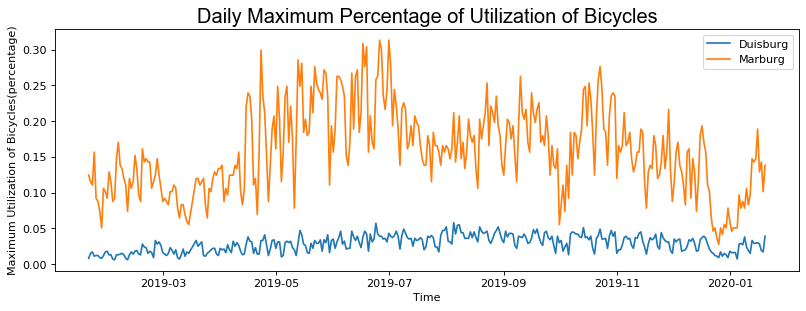

In [38]:
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail_percentage_duis)
ax.plot(max_avail_percentage_mar)
ax.set_title("Daily Maximum Percentage of Utilization of Bicycles", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Maximum Utilization of Bicycles(percentage)")
ax.legend(["Duisburg", "Marburg"])
plt.show()

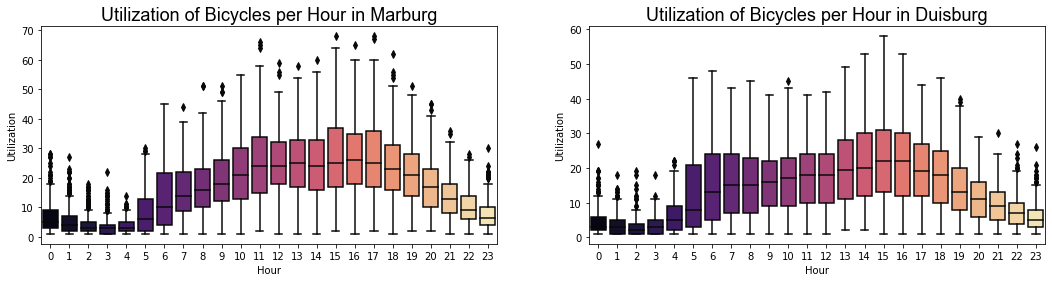

In [39]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4)) 

sns.boxplot(x=kpi_mar_time_util.index.get_level_values(1), y=kpi_mar_time_util["util"],ax=ax[0], palette="magma")
ax[0].set_title("Utilization of Bicycles per Hour in Marburg", fontsize=18, fontname="Arial")
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Utilization")

sns.boxplot(x=kpi_duis_time_util.index.get_level_values(1), y=kpi_duis_time_util["util"],ax=ax[1], palette="magma")
ax[1].set_title("Utilization of Bicycles per Hour in Duisburg", fontsize=18, fontname="Arial")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Utilization")
plt.show()

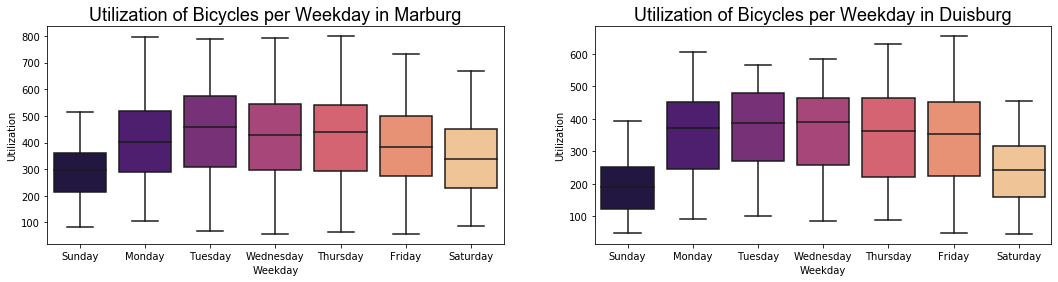

In [40]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4)) 

sns.boxplot(x=kpi_mar_weekday_util.index.get_level_values(1), y=kpi_mar_weekday_util["util"],ax=ax[0], palette="magma")
ax[0].set_title("Utilization of Bicycles per Weekday in Marburg", fontsize=18, fontname="Arial")
ax[0].set_xlabel("Time")
ax[0].set_xlabel("Weekday")
ax[0].set_ylabel("Utilization")

sns.boxplot(x=kpi_duis_weekday_util.index.get_level_values(1), y=kpi_duis_weekday_util["util"],ax=ax[1], palette="magma")
ax[1].set_title("Utilization of Bicycles per Weekday in Duisburg", fontsize=18, fontname="Arial")
ax[1].set_xlabel("Weekday")
ax[1].set_ylabel("Utilization")
plt.show()

# Fleet distance traveled (Tim)

This key performance indicator covers the sum of all kilometres traveled by all bikes in the span of an hour. 

To compute this KPI, we first have to calculate the distance of each individual ride, which we then sum up for every hour, to visualize the distance traveled by the entire fleet in each hour.

## Adding trip_distance for each ride:

Let us start by reading in the cleaned dataset for Marburg:

In [26]:
# Reading the clean pickle file.
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')

# Here is a quick overview:
marburg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164057 entries, 2019-07-04 13:29:00 to 2019-05-20 09:38:00
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   day                 164057 non-null  object
 1   time                164057 non-null  object
 2   b_number            164057 non-null  int64 
 3   city                164057 non-null  object
 4   orig                164057 non-null  object
 5   dest                164057 non-null  object
 6   weekday             164057 non-null  int64 
 7   hour                164057 non-null  int64 
 8   trip_duration_mins  164057 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 12.5+ MB


Because we will need them individually for the function that computes the distance traveled by each ride, we are extracting the latitude and longitude values from the origin and destination coordinates.

To do this we are using the zip* function:

In [27]:
marburg["lat_orig_test"], marburg["lon_orig_test"] =  zip(*marburg["orig"])
marburg["lat_dest_test"], marburg["lon_dest_test"] =  zip(*marburg["dest"])

#This is what the dataframe looks like now:
marburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,lat_orig_test,lon_orig_test,lat_dest_test,lon_dest_test
datetime,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,50.8081,8.7754,50.8110,8.7742
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,50.7987,8.7530,50.8058,8.7828
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,50.8058,8.7828,50.8229,8.7747
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,50.8200,8.7737,50.7856,8.7794
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,50.7856,8.7794,50.7952,8.7633


To calculate the distance traveled for each ride, we are defining a function called 'distance', which calculates the distance between two latitude and longitude values.

This function also factors in the curvature of the earth instead of just computing the exact distance.

In [28]:
def distance(lat1, lon1, lat2, lon2):
    
    radius = 6371 # km, we have to adjust to the earths curvature so we have to input the radius of the earth as well.
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

Here we get the values of the latitude and longitude from the origin and destination coordinates (without the index) and save it in individual arrays, so we can access these values easily for the 'distance' function.

In [29]:
array_lat_orig = marburg.loc[:, 'lat_orig_test'].values
array_lon_orig = marburg.loc[:, 'lon_orig_test'].values
array_lat_dest = marburg.loc[:, 'lat_dest_test'].values
array_lon_dest = marburg.loc[:, 'lon_dest_test'].values


To calculate our values, we are creating a new array 'b' with the same amount of entries as the dataset.
Then we are using a for loop to call the 'distance' function for each cell in 'b', which calculates the distance between the origin and destination for every single ride.

Afterwards we save the values from 'b' (the distance of every single trip) in the dataframe as a new column called 'trip_distance'.

In [30]:
a = len(marburg)
b = [0]*a

for i in range(a):
    b[i] = distance(array_lat_orig[i], array_lon_orig[i], array_lat_dest[i], array_lon_dest[i])
    
marburg["trip_distance"] = b

# Here is what the dataframe looks like now (You might have to scroll right to see the added column 'trip_distance').
marburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,lat_orig_test,lon_orig_test,lat_dest_test,lon_dest_test,trip_distance
datetime,,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,50.8081,8.7754,50.8110,8.7742,0.333306
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,50.7987,8.7530,50.8058,8.7828,2.238067
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,50.8058,8.7828,50.8229,8.7747,1.984767
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,50.8200,8.7737,50.7856,8.7794,3.846022
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,50.7856,8.7794,50.7952,8.7633,1.555723


Now that we have calculated the distance of each individual ride, we can once again drop the individual latitude and longitude values for the origin and destination to clean up the dataframe a bit.

In [31]:
marburg.drop(columns=['lat_orig_test','lon_orig_test','lat_dest_test','lon_dest_test'], axis=1, inplace = True)

# Looks a lot better, doesn't it?
marburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,trip_distance
datetime,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,0.333306
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2.238067
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,1.984767
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,3.846022
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,1.555723


Here we are repeating the stame steps with the Duisburg data:

In [32]:
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')

duisburg["lat_orig_test"], duisburg["lon_orig_test"] =  zip(*duisburg["orig"])
duisburg["lat_dest_test"], duisburg["lon_dest_test"] =  zip(*duisburg["dest"])

array_lat_orig_2 = duisburg.loc[:, 'lat_orig_test'].values
array_lon_orig_2 = duisburg.loc[:, 'lon_orig_test'].values
array_lat_dest_2 = duisburg.loc[:, 'lat_dest_test'].values
array_lon_dest_2 = duisburg.loc[:, 'lon_dest_test'].values

a = len(duisburg)
c = [0]*a

for i in range(a):
    c[i] = distance(array_lat_orig_2[i], array_lon_orig_2[i], array_lat_dest_2[i], array_lon_dest_2[i])
    
duisburg["trip_distance"] = c

duisburg.drop(columns=['lat_orig_test','lon_orig_test','lat_dest_test','lon_dest_test'], axis=1, inplace = True)

# Now the dataframe looks the same as the one for Marburg (with the trip_distance included).
duisburg.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,trip_distance
datetime,,,,,,,,,,
2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,1.457762
2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,1.869223
2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,0.678440
2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,0.390406
2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,1.869075


## Visualizing the distance traveled:

Let's start with the Marburg data first again.

Because we want out KPI's to be hourly, we start by creating a new column called 'start', that rounds down the start time of any ride to the hour.
We'll use this column later to sum up all the rides that take place during each single hour.

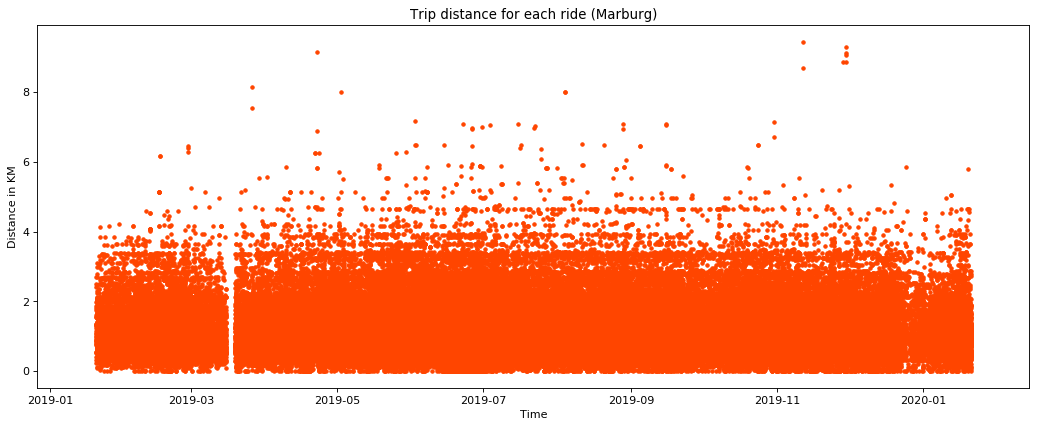

In [33]:
marburg['start'] = marburg.index.floor(freq = "H")

# Creating a simple scatter plot to show all of the distances of each individual ride.
fig,ax = plt.subplots(figsize=(16,6), dpi= 80) 
ax.scatter(marburg["start"], marburg["trip_distance"], color = 'orangered', marker ='.')
ax.set_title("Trip distance for each ride (Marburg)")
ax.set_xlabel("Time")
ax.set_ylabel("Distance in KM")
plt.show()

These are just the distances of each individual ride. However, what we are looking for is the distance traveled by the entire fleet in the span of an hour.

To sum up the trip_distances of all rides that took place in one hour we are creating a new Dataframe:

In [34]:
hourly_distance_marburg = pd.DataFrame()
hourly_distance_marburg["distance"] = marburg["trip_distance"].groupby(marburg["start"]).sum()

# This is what the Dataframe looks like
hourly_distance_marburg.head()

,distance
start,
2019-01-20 00:00:00,8.413924
2019-01-20 01:00:00,12.283895
2019-01-20 02:00:00,5.552752
2019-01-20 03:00:00,0.559740
2019-01-20 04:00:00,2.730626


Now, let us visualize the total distance traveled by all bikes in the span of an hour, starting with Marburg:

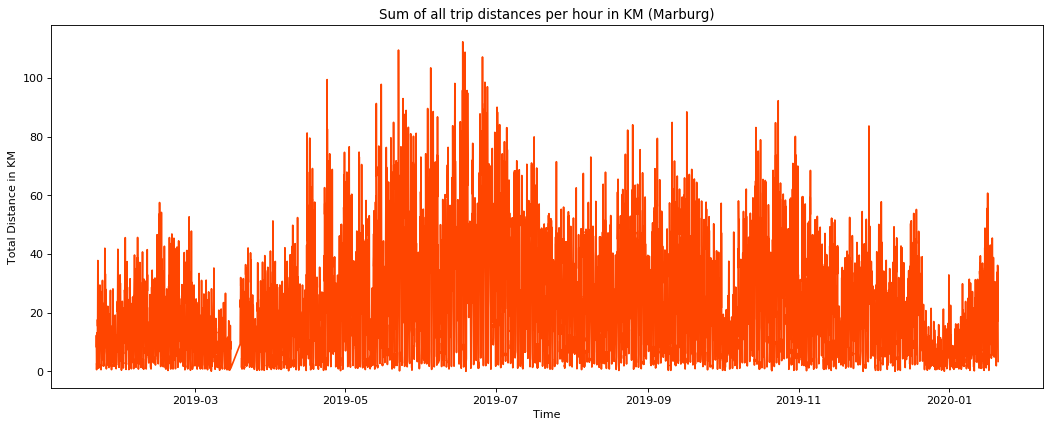

In [35]:
fig,ax = plt.subplots(figsize=(16,6), dpi= 80) 
ax.plot(hourly_distance_marburg["distance"], color = 'orangered')
ax.set_title("Sum of all trip distances per hour in KM (Marburg)")
ax.set_xlabel("Time")
ax.set_ylabel("Total Distance in KM")
plt.savefig("trip distances for each hour marburg.pdf")
plt.show()

We will once again repeat this for the Duisburg data:


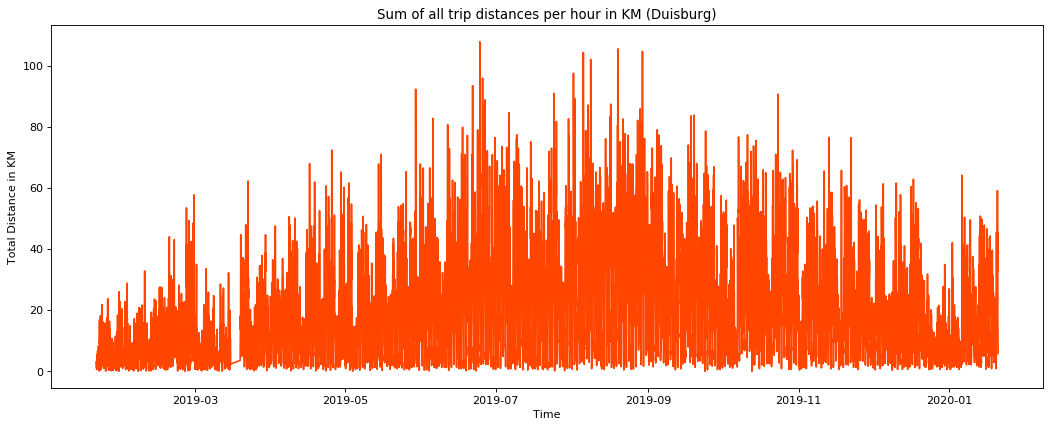

In [36]:
duisburg['start'] = duisburg.index.floor(freq = "H")
hourly_distance_duisburg = pd.DataFrame()
hourly_distance_duisburg["distance"] = duisburg["trip_distance"].groupby(duisburg["start"]).sum()
fig,ax = plt.subplots(figsize=(16,6), dpi= 80) 
ax.plot(hourly_distance_duisburg["distance"], color = 'orangered')
ax.set_title("Sum of all trip distances per hour in KM (Duisburg)")
ax.set_xlabel("Time")
ax.set_ylabel("Total Distance in KM")
plt.savefig("trip distances for each hour duisburg.pdf")
plt.show()

### Resampling to weekly distance traveled

To better visualize the data, let us resample the distance traveled by the entire fleet to the span of a week.

We are doing this for both the Marburg and Duisburg data in a single graph to compare how well their respective fleets are performing during the observed timespan.

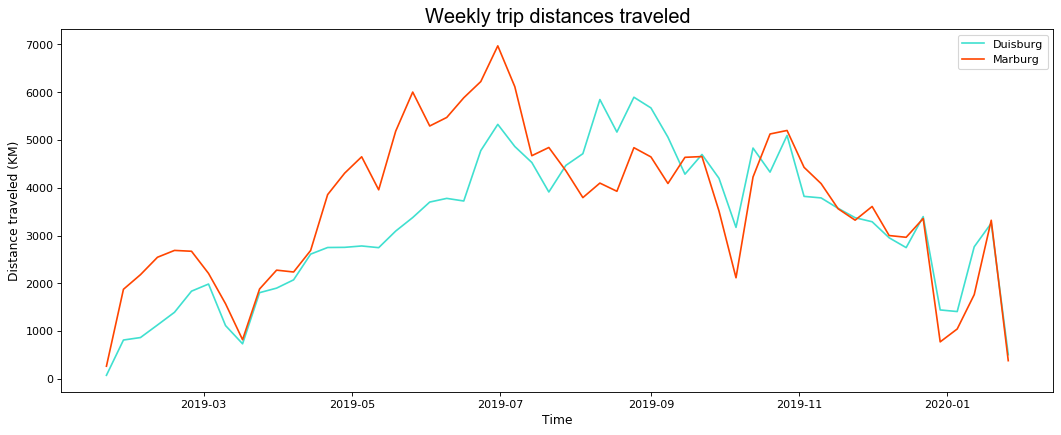

<Figure size 432x288 with 0 Axes>

In [37]:
fig,ax = plt.subplots(figsize=(16,6), dpi= 80) 

ax.plot(hourly_distance_duisburg["distance"].resample("w").sum(), color = 'turquoise')
ax.plot(hourly_distance_marburg["distance"].resample("w").sum(), color = 'orangered')
ax.set_title("Weekly trip distances traveled", fontsize=18, fontname="Arial")
ax.set_xlabel("Time", fontsize =11)
ax.set_ylabel("Distance traveled (KM)", fontsize = 11)
ax.legend(["Duisburg", "Marburg"])
plt.show()

plt.savefig("KPI_Distance_Traveled_Resampled.pdf")

As you can see, the total distance traveled by the fleet is significantly higher in the summer months, which is to be expected as more bikes are being rented during those months.

Also, when comparing the distance traveled by rented bikes in each city, we can observe that there are no big differnces between the two datasets, with both cities averaging more traveled kilometres in the summer months than in the rest of the year and both graphs following a similar curve.

Especially when looking at the resampled data, you can see that the total distance traveled by the whole fleet is a very helpful key performance indicator, because you can easily tell how well the fleet is doing during any given timespan and then try to find reasons as to why the fleet is performing well or poorly, which is why we have chosen the 'Total Distance traveled' as one of our KPIs.

## Quality of fleet (Julia)

Another key performance indicator is the quality of the bicycles.   
We can assume that if a bicycle is not used for 4 weeks or longer it is probably broken or can't be accessed.
The percentage of bicycles that overstep this threshold value can tells us the quality of the fleet.

In [38]:
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')

## Duisburg

In [39]:
duisburg = duisburg.sort_values(['datetime']) #first we sort the values by time
duisburg = duisburg.reset_index() #and reset the index because we need the datetimecolumn
duisburg

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins
0,2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10
1,2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13
2,2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121
3,2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9
4,2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6
...,...,...,...,...,...,...,...,...,...,...
131914,2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6
131915,2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15
131916,2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7
131917,2020-01-20 23:33:00,2020-01-20,23:33:00,501533,duisburg,"(51.4104, 6.7521)","(51.4178, 6.7575)",0,23,18


In [40]:
def calc_length(df): #we compute the difference between the datetimes 
    df['diff'] = df['datetime'].diff(periods=-1) #periods=-1 asssures that we use the row under the current one 
    return df

In [41]:
#now we apply the calculation of the difference grouped by bike
duisburg_diff = duisburg.groupby(['b_number'], sort=False).apply(calc_length)
duisburg_diff

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
0,2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10,-1 days +22:37:00
1,2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00
2,2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121,-2 days +18:43:00
3,2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9,-1 days +19:41:00
4,2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6,-1 days +17:31:00
...,...,...,...,...,...,...,...,...,...,...,...
131914,2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6,NaT
131915,2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15,NaT
131916,2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7,NaT
131917,2020-01-20 23:33:00,2020-01-20,23:33:00,501533,duisburg,"(51.4104, 6.7521)","(51.4178, 6.7575)",0,23,18,NaT


In [42]:
# An example to show that it worked
duisburg_diff.sort_values(['b_number','datetime'])[duisburg_diff['b_number']==683]

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,NaT


The timedeltas are negative because we calculated backwards.  
Also we can see that the last entry of course is Nat because we had no more rows to compute it. That's why we now compute it with the time of the last dataentry. 

In [43]:
duisburg['datetime'].max() #latest datetime

Timestamp('2020-01-20 23:48:00')

In [44]:
def fill_NaT(row): #fills the rows with NaT
    if pd.isnull(row['diff']):
        end = pd.Timestamp(year=2020, month=1, day=21)
        row['diff'] = row['datetime'] - end
    return row

In [45]:
duisburg_diff = duisburg_diff.apply(fill_NaT, axis=1) #we apply our fill_NaT method

In [46]:
#again an example to look if it worked
duisburg_diff[duisburg_diff['b_number']==683]

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,-230 days +10:35:00


The last entry is not negative so we have to consider this.

In [47]:
#Every bike that was not used longer than 28 days
duisburg_diff['is_broken'] = (duisburg_diff['diff'] < timedelta(days=-28)) | (duisburg_diff['diff'] > timedelta(days=28))

In [48]:
duisburg_diff[duisburg_diff['b_number']==683] #example bike

,datetime,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
27613,2019-05-27 14:48:00,2019-05-27,14:48:00,683,duisburg,"(51.426, 6.7649)","(51.4283, 6.7856)",0,14,73,-1 days +21:28:00,False
27675,2019-05-27 17:20:00,2019-05-27,17:20:00,683,duisburg,"(51.4283, 6.7856)","(51.4314, 6.7591)",0,17,44,-1 days +09:01:00,False
27829,2019-05-28 08:19:00,2019-05-28,08:19:00,683,duisburg,"(51.4314, 6.7591)","(51.4333, 6.7684)",1,8,6,-8 days +23:06:00,False
30425,2019-06-04 09:13:00,2019-06-04,09:13:00,683,duisburg,"(51.4341, 6.7627)","(51.4314, 6.7591)",1,9,12,-1 days +00:05:00,False
30907,2019-06-05 09:08:00,2019-06-05,09:08:00,683,duisburg,"(51.4314, 6.7591)","(51.4393, 6.7829)",2,9,52,-1 days +22:33:00,False
30940,2019-06-05 10:35:00,2019-06-05,10:35:00,683,duisburg,"(51.4393, 6.7829)","(51.4306, 6.7735)",2,10,41,-230 days +10:35:00,True


Now there is a binary factor stating whether a bicycle is broken.

In [49]:
duisburg_diff = duisburg_diff.set_index('datetime') #setting the index to the datetimecolumn again
duisburg_diff

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
datetime,,,,,,,,,,,
2019-01-20 00:31:00,2019-01-20,00:31:00,51129,duisburg,"(51.4393, 6.7829)","(51.4294, 6.7772)",6,0,10,-1 days +22:37:00,False
2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00,True
2019-01-20 01:21:00,2019-01-20,01:21:00,51465,duisburg,"(51.4281, 6.7792)","(51.432, 6.7712)",6,1,121,-2 days +18:43:00,False
2019-01-20 01:54:00,2019-01-20,01:54:00,51129,duisburg,"(51.4304, 6.7748)","(51.4223, 6.7918)",6,1,9,-1 days +19:41:00,False
2019-01-20 05:37:00,2019-01-20,05:37:00,51299,duisburg,"(51.4294, 6.7772)","(51.4245, 6.7815)",6,5,6,-1 days +17:31:00,False
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 22:48:00,2020-01-20,22:48:00,52171,duisburg,"(51.4283, 6.7856)","(51.4294, 6.7772)",0,22,6,-1 days +22:48:00,False
2020-01-20 23:22:00,2020-01-20,23:22:00,51585,duisburg,"(51.4558, 6.735)","(51.4367, 6.7576)",0,23,15,-1 days +23:22:00,False
2020-01-20 23:24:00,2020-01-20,23:24:00,501570,duisburg,"(51.4319, 6.7784)","(51.4302, 6.762)",0,23,7,-1 days +23:24:00,False


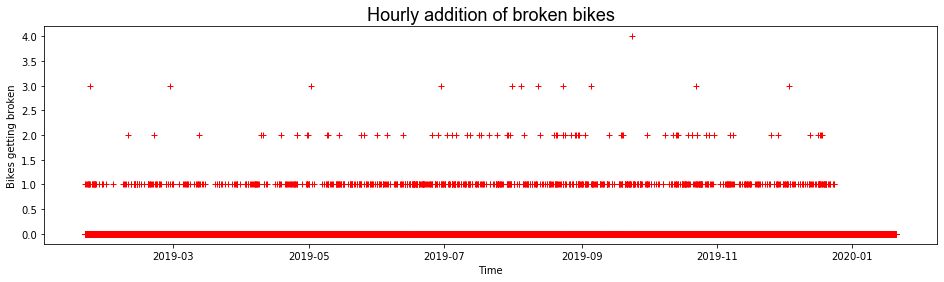

In [50]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(duisburg_diff.resample('h')['is_broken'].sum(), 'r+') #plotting the bikes getting broken per hour
ax.set_title("Hourly addition of broken bikes",  fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

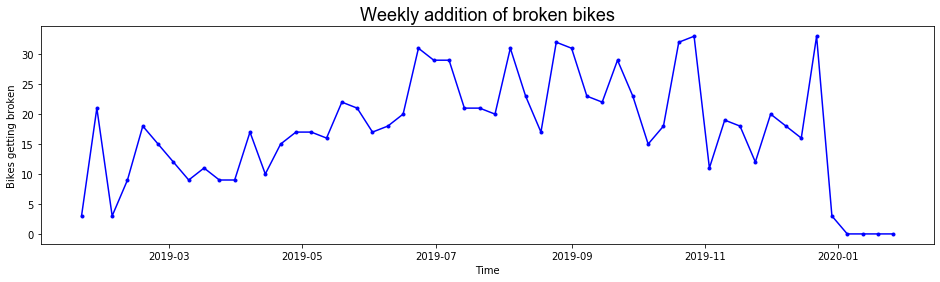

In [51]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(duisburg_diff.resample('w')['is_broken'].sum(), 'b.-') #plotting the bikes getting broken per week
ax.set_title("Weekly addition of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

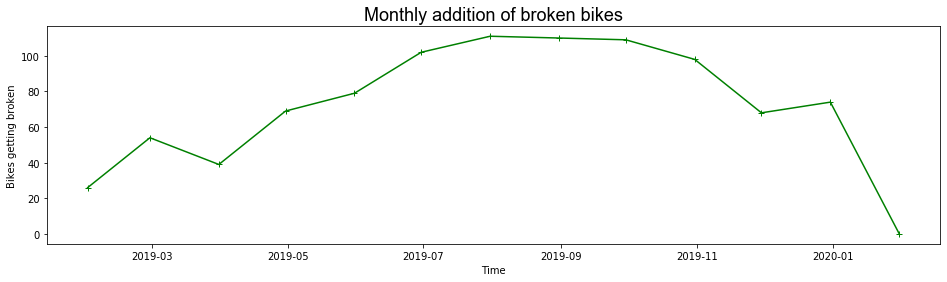

In [52]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(duisburg_diff.resample('m')['is_broken'].sum(), 'g+-') #plotting the bikes getting broken per month
ax.set_title("Monthly addition of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

In [53]:
duisburg_diff.resample('m')['is_broken'].sum() #to see the exact values

datetime
2019-01-31     26.0
2019-02-28     54.0
2019-03-31     39.0
2019-04-30     69.0
2019-05-31     79.0
2019-06-30    102.0
2019-07-31    111.0
2019-08-31    110.0
2019-09-30    109.0
2019-10-31     98.0
2019-11-30     68.0
2019-12-31     74.0
2020-01-31      0.0
Freq: M, Name: is_broken, dtype: float64

The trend of the bicycles getting broken in a week is an up and down with peaks around 30 broken bicycles per week.   
When we take a look at the monthly curve we can see that around november until may there are less broken bicycles per month (<98) than in the more summmerly months.

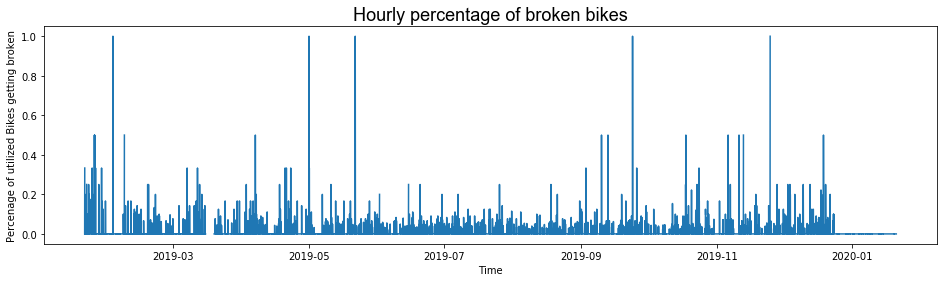

In [54]:
#now we compute the percentage of broken bikes in terms of utilization

fig,ax = plt.subplots(figsize=(16,4))

ax.plot(duisburg_diff.resample('h')['is_broken'].sum()/kpi_duis.resample('h')['util'].sum()) #percentage of broken bikes per hour
ax.set_title("Hourly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

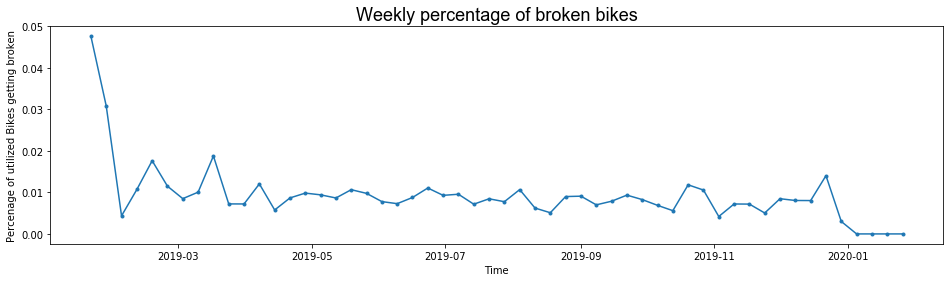

In [55]:
fig,ax = plt.subplots(figsize=(16,4))

ax.plot(duisburg_diff.resample('w')['is_broken'].sum()/kpi_duis.resample('w')['util'].sum(), '.-') #percentage of broken bikes per week
ax.set_title("Weekly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

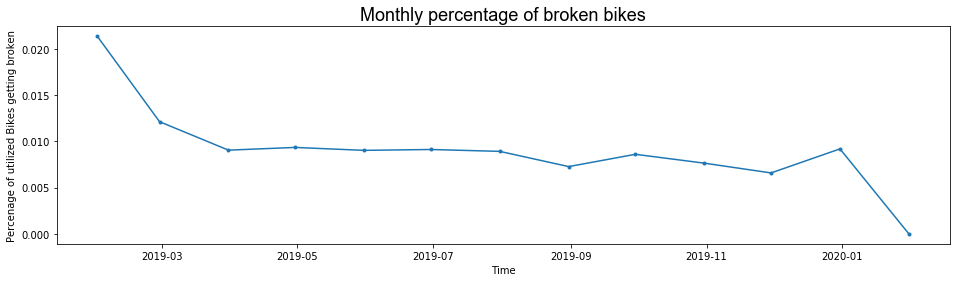

In [56]:
fig,ax = plt.subplots(figsize=(16,4))

ax.plot(duisburg_diff.resample('m')['is_broken'].sum()/kpi_duis.resample('m')['util'].sum(), '.-') #percentage of broken bikes per month
ax.set_title("Monthly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

In the graph showing the percentage of broken bicycles over the utilized bicycles, we can see that the monthly percentage stays mostly stable over the year. The exception with a high percentage at the beginning of the year can be explained with winter weather where maybe more bicycles get broke. The last monthly data entry should not be considered because the time difference to the end of the dataset is of course mostly below 4 weeks in this last month.

In [57]:
#computing the cumulative number of broken bikes over time
#(if a bike is broken twice this also counts as 2 bikes)
duisburg_diff_true = duisburg_diff[duisburg_diff['is_broken']==True] # a dataframe with only broken bikes entries
duisburg_diff_true["cumulative_broken_bikes"] = range(0,len(duisburg_diff_true), 1) #counting the broken bikes over the year
duisburg_diff_true

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken,cumulative_broken_bikes
datetime,,,,,,,,,,,,
2019-01-20 01:11:00,2019-01-20,01:11:00,50113,duisburg,"(51.4319, 6.7784)","(51.4341, 6.7627)",6,1,13,-165 days +19:00:00,True,0
2019-01-20 16:52:00,2019-01-20,16:52:00,53061,duisburg,"(51.4319, 6.7784)","(51.4223, 6.7918)",6,16,11,-366 days +16:52:00,True,1
2019-01-20 22:44:00,2019-01-20,22:44:00,53307,duisburg,"(51.4294, 6.7772)","(51.4347, 6.7698)",6,22,5,-188 days +22:39:00,True,2
2019-01-21 09:08:00,2019-01-21,09:08:00,52119,duisburg,"(51.4302, 6.762)","(51.4272, 6.7977)",0,9,55,-47 days +01:44:00,True,3
2019-01-21 16:35:00,2019-01-21,16:35:00,52974,duisburg,"(51.4352, 6.7617)","(51.4558, 6.735)",0,16,16,-30 days +06:14:00,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-22 00:47:00,2019-12-22,00:47:00,51034,duisburg,"(51.4319, 6.7784)","(51.4677, 6.7801)",6,0,37,-30 days +00:47:00,True,934
2019-12-22 03:45:00,2019-12-22,03:45:00,50510,duisburg,"(51.4319, 6.7784)","(51.4314, 6.7591)",6,3,10,-30 days +03:45:00,True,935
2019-12-23 09:52:00,2019-12-23,09:52:00,500973,duisburg,"(51.4273, 6.7978)","(51.4378, 6.7772)",0,9,31,-29 days +09:52:00,True,936


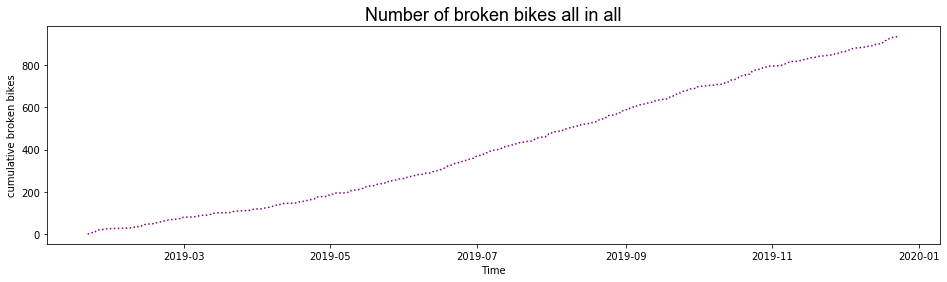

In [58]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(duisburg_diff_true["cumulative_broken_bikes"], ':', color='purple') #plotting all broken bikes over the year
ax.set_title("Number of broken bikes all in all", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("cumulative broken bikes")

plt.show()

The increase in broken bikes seems to be linear.

## Marburg

In [59]:
#now we do the same as above for marburg
marburg = marburg.sort_values(['datetime'])
marburg = marburg.reset_index()
marburg_diff = marburg.groupby(['b_number'], sort=False).apply(calc_length)
marburg_diff = marburg_diff.apply(fill_NaT, axis=1)
marburg_diff['is_broken'] = (marburg_diff['diff'] < timedelta(days=-28)) | (marburg_diff['diff'] > timedelta(days=28))
marburg_diff = marburg_diff.set_index('datetime')
marburg_diff

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken
datetime,,,,,,,,,,,
2019-01-20 00:04:00,2019-01-20,00:04:00,11181,marburg,"(50.7973, 8.7616)","(50.8081, 8.7753)",6,0,11,-1 days +07:25:00,False
2019-01-20 00:08:00,2019-01-20,00:08:00,11126,marburg,"(50.7988, 8.7621)","(50.8132, 8.7759)",6,0,18,-1 days +23:32:00,False
2019-01-20 00:08:00,2019-01-20,00:08:00,11103,marburg,"(50.7988, 8.7621)","(50.8045, 8.7704)",6,0,9,-1 days +22:37:00,False
2019-01-20 00:25:00,2019-01-20,00:25:00,11113,marburg,"(50.8071, 8.7699)","(50.8047, 8.7592)",6,0,29,-1 days +09:05:00,False
2019-01-20 00:36:00,2019-01-20,00:36:00,11126,marburg,"(50.8132, 8.7759)","(50.8132, 8.7633)",6,0,5,-1 days +09:35:00,False
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20 22:50:00,2020-01-20,22:50:00,11124,marburg,"(50.8165, 8.7792)","(50.8094, 8.7722)",0,22,9,-1 days +22:50:00,False
2020-01-20 23:06:00,2020-01-20,23:06:00,11297,marburg,"(50.8089, 8.773)","(50.82, 8.7737)",0,23,7,-1 days +23:06:00,False
2020-01-20 23:16:00,2020-01-20,23:16:00,11263,marburg,"(50.8016, 8.7597)","(50.7953, 8.762)",0,23,6,-1 days +23:16:00,False


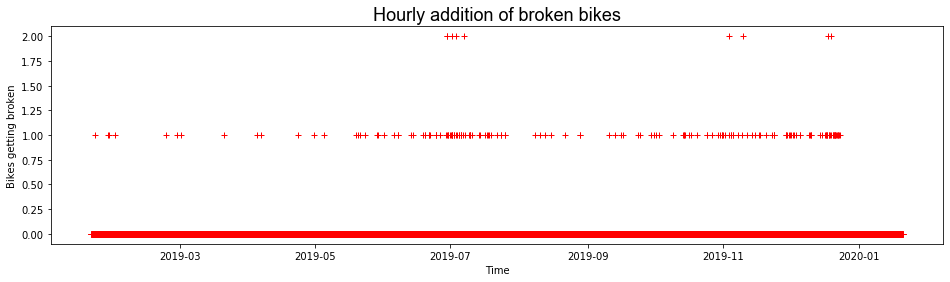

In [60]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(marburg_diff.resample('h')['is_broken'].sum(), 'r+') #plotting the bikes getting broken per hour
ax.set_title("Hourly addition of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

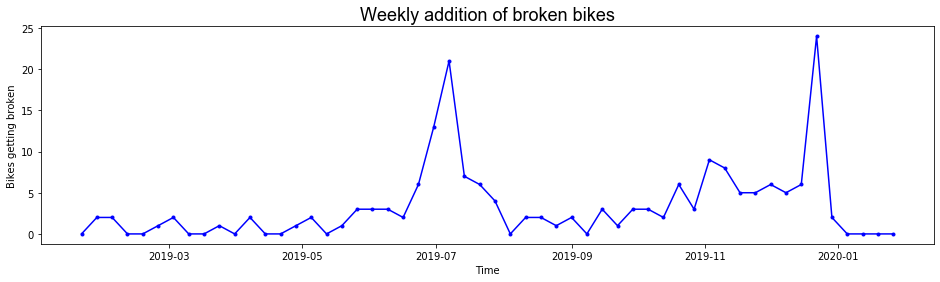

In [61]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(marburg_diff.resample('w')['is_broken'].sum(), 'b.-') #plotting the bikes getting broken per week
ax.set_title("Weekly addition of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

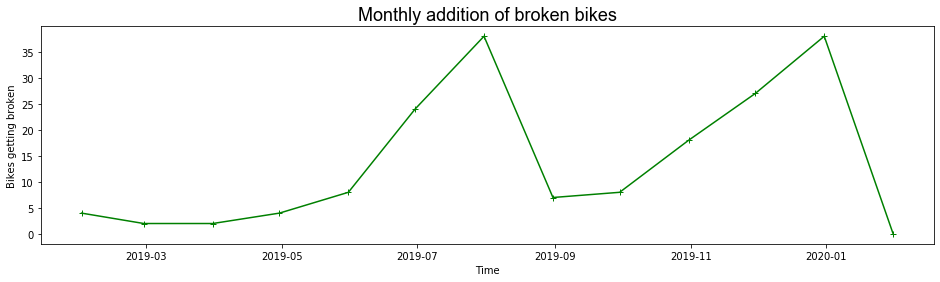

In [62]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(marburg_diff.resample('m')['is_broken'].sum(), 'g+-') #plotting the bikes getting broken per month
ax.set_title("Monthly addition of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bikes getting broken")

plt.show()

In [63]:
marburg_diff.resample('m')['is_broken'].sum() #to see the exact values

datetime
2019-01-31     4.0
2019-02-28     2.0
2019-03-31     2.0
2019-04-30     4.0
2019-05-31     8.0
2019-06-30    24.0
2019-07-31    38.0
2019-08-31     7.0
2019-09-30     8.0
2019-10-31    18.0
2019-11-30    27.0
2019-12-31    38.0
2020-01-31     0.0
Freq: M, Name: is_broken, dtype: float64

The trend of bicycles getting broken in a month in Marburg is low (<10) except for june - july and october - december.   
This could be corrolated with a higher utilization in the summer months and bad weather in the winter months. 
With a higher utilization comes a higher risk of getting a bicycle broken and in winter rainy weather can also increase the probability of a broken bicycle. 

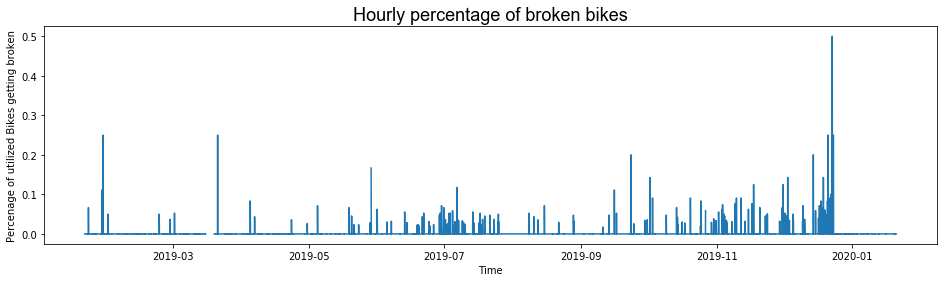

In [64]:
#now we compute the percentage of broken bikes in terms of utilization

fig,ax = plt.subplots(figsize=(16,4))

ax.plot(marburg_diff.resample('h')['is_broken'].sum()/kpi_mar.resample('h')['util'].sum()) #percentage of broken bikes per hour
ax.set_title("Hourly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

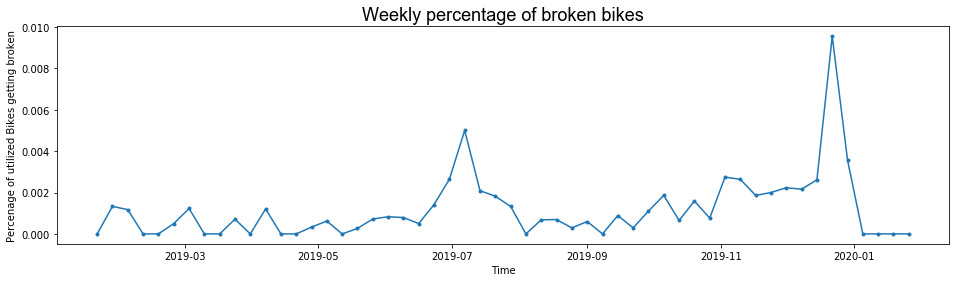

In [65]:
fig,ax = plt.subplots(figsize=(16,4))

ax.plot(marburg_diff.resample('w')['is_broken'].sum()/kpi_mar.resample('w')['util'].sum(), '.-') #percentage of broken bikes per week
ax.set_title("Weekly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

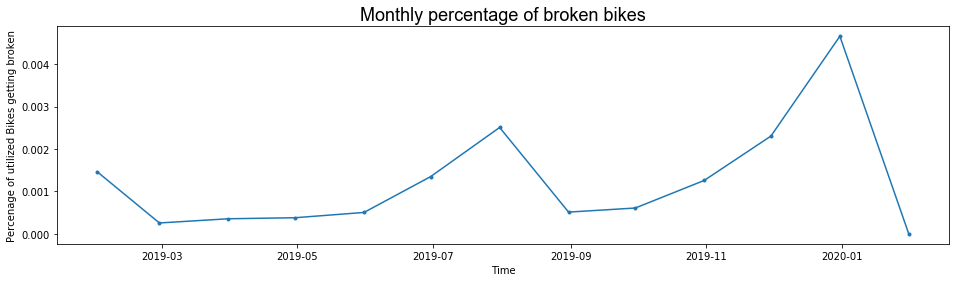

In [66]:
fig,ax = plt.subplots(figsize=(16,4))

ax.plot(marburg_diff.resample('m')['is_broken'].sum()/kpi_mar.resample('m')['util'].sum(), '.-') #percentage of broken bikes per month
ax.set_title("Monthly percentage of broken bikes", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percenage of utilized Bikes getting broken")

plt.show()

Here we can see that the monthly percentage as well has a peak in summer and an even higher peak in the winter.  
So the summer peak is not correlated to the utilization as earlier expected.
The last monthly data entry again should not be considered.

In [67]:
marburg_diff_true = marburg_diff[marburg_diff['is_broken']==True] # a dataframe with only broken bikes entries
marburg_diff_true["cumulative_broken_bikes"] = range(0,len(marburg_diff_true), 1) #counting the broken bikes over the year
marburg_diff_true

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,diff,is_broken,cumulative_broken_bikes
datetime,,,,,,,,,,,,
2019-01-21 17:44:00,2019-01-21,17:44:00,11196,marburg,"(50.8098, 8.7794)","(50.8089, 8.7731)",0,17,17,-365 days +17:44:00,True,0
2019-01-27 19:14:00,2019-01-27,19:14:00,11214,marburg,"(50.8229, 8.7747)","(50.8136, 8.7737)",6,19,7,-359 days +19:14:00,True,1
2019-01-28 06:55:00,2019-01-28,06:55:00,11108,marburg,"(50.8045, 8.7704)","(50.7988, 8.7621)",0,6,6,-358 days +06:55:00,True,2
2019-01-30 13:35:00,2019-01-30,13:35:00,11272,marburg,"(50.8362, 8.7568)","(50.8229, 8.7747)",2,13,23,-149 days +01:05:00,True,3
2019-02-22 15:09:00,2019-02-22,15:09:00,11189,marburg,"(50.8089, 8.773)","(50.8229, 8.7747)",4,15,10,-333 days +15:09:00,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-22 11:03:00,2019-12-22,11:03:00,11126,marburg,"(50.7988, 8.7621)","(50.82, 8.7737)",6,11,18,-30 days +11:03:00,True,175
2019-12-22 20:10:00,2019-12-22,20:10:00,11199,marburg,"(50.7895, 8.7564)","(50.8033, 8.7641)",6,20,12,-30 days +20:10:00,True,176
2019-12-22 21:54:00,2019-12-22,21:54:00,11081,marburg,"(50.8058, 8.7828)","(50.7988, 8.7621)",6,21,22,-30 days +21:54:00,True,177


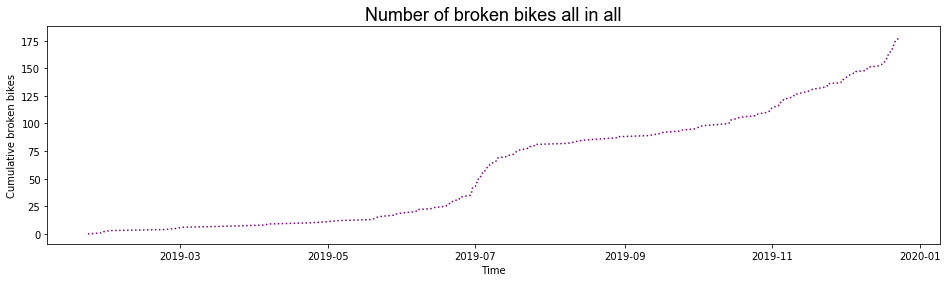

In [68]:
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(marburg_diff_true["cumulative_broken_bikes"], ':',color='purple') #plotting all broken bikes over the year
ax.set_title("Number of broken bikes all in all", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative broken bikes")

plt.show()

Again we can see the increase in broken bikes in Marburg seems to be way higher in june and july than in the other months. Another bigger increase is seen in and around november.

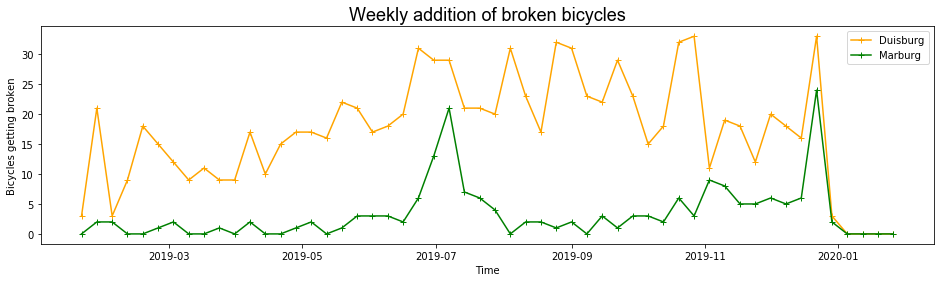

In [69]:
#plotting both weekly additions of broken bikes
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(duisburg_diff.resample('w')['is_broken'].sum(), '+-', color='orange', label='Duisburg') #plotting the bicycles getting broken per week
ax.plot(marburg_diff.resample('w')['is_broken'].sum(), 'g+-', label='Marburg') #plotting the bicycles getting broken per week
ax.set_title("Weekly addition of broken bicycles", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Bicycles getting broken")

plt.legend(loc=0)
#plt.savefig("Weekly addition of broken bicycles.pdf")

plt.show()

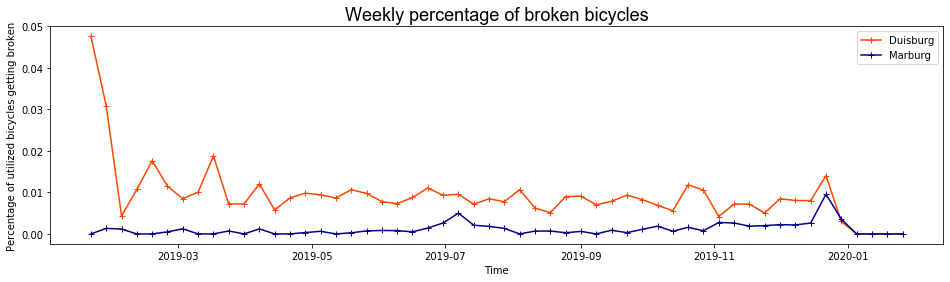

In [70]:
fig,ax = plt.subplots(figsize=(16,4))

ax.plot(duisburg_diff.resample('w')['is_broken'].sum()/kpi_duis.resample('w')['util'].sum(),'+-', color='orangered', label='Duisburg') #percentage of broken bicycles per week
ax.plot(marburg_diff.resample('w')['is_broken'].sum()/kpi_mar.resample('w')['util'].sum(), '+-', color='darkblue', label='Marburg') #percentage of broken bicycles per week
ax.set_title("Weekly percentage of broken bicycles", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Percentage of utilized bicycles getting broken")

plt.legend(loc=0)
#plt.savefig("Weekly percentage of broken bicycles.pdf")

plt.show()

In Duisburg bicycles are getting broken mostly all year whereas Marburg's bicycles are having a peak in summer and winter. In the cumulative graph comparison the stable rise in Duisburg and the peaks in Marburg can be seen clearly.
Marburg still has less broken bicycles all in all. This could be because it has less citizens (ca. 80.000) than Duisburg (ca. 490.000). 

## Spread of fleet / coverage (Moritz)

## Revenue (Jan) 

Revenue describes the amount of 30 minute units, because you pay the bike for each started 30 min. Therefore the actual revenue might be different from an simple extrapolation of the trip duration.

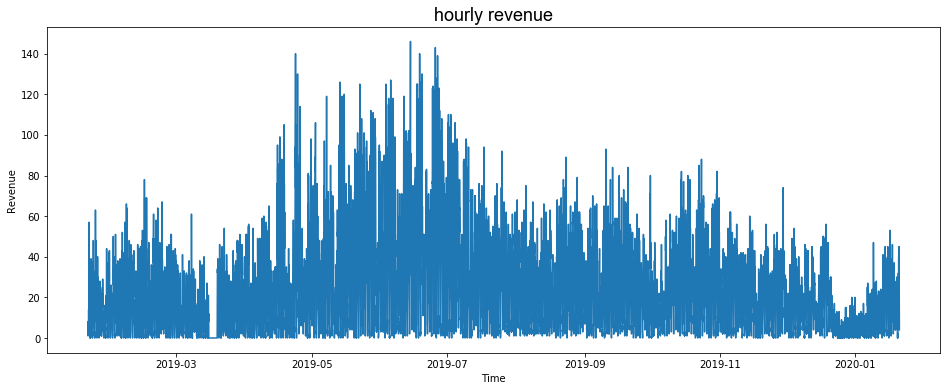

In [71]:
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
rev_marburg = marburg.sort_values(['datetime'])
rev_marburg['revenue'] = rev_marburg['trip_duration_mins']/30
rev_marburg['revenue'] = rev_marburg['revenue']+0.999 #because you pay the bike per 30 min rounded up
rev_marburg['revenue'] = rev_marburg['revenue'] - rev_marburg['revenue']%1
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_marburg.resample('h')['revenue'].sum()) #plotting the Revenue per hour
ax.set_title("hourly revenue",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")

plt.show()

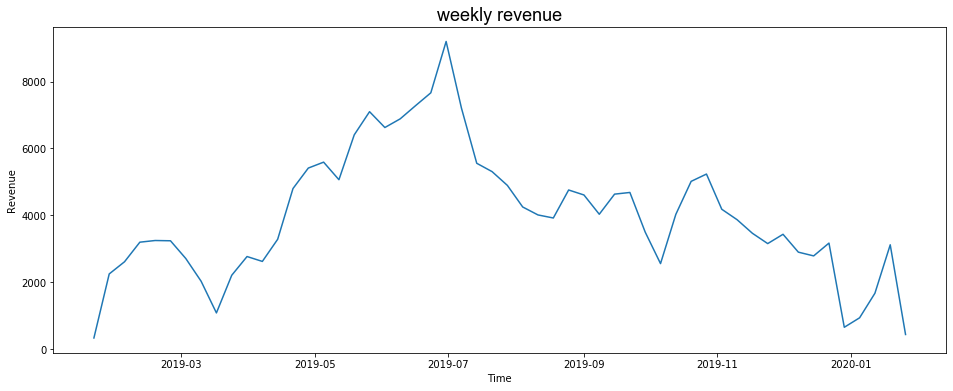

In [72]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_marburg.resample('w')['revenue'].sum()) #plotting the Revenue per hour
ax.set_title("weekly revenue",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.savefig('weekly_revenue_marburg.pdf')
plt.show()


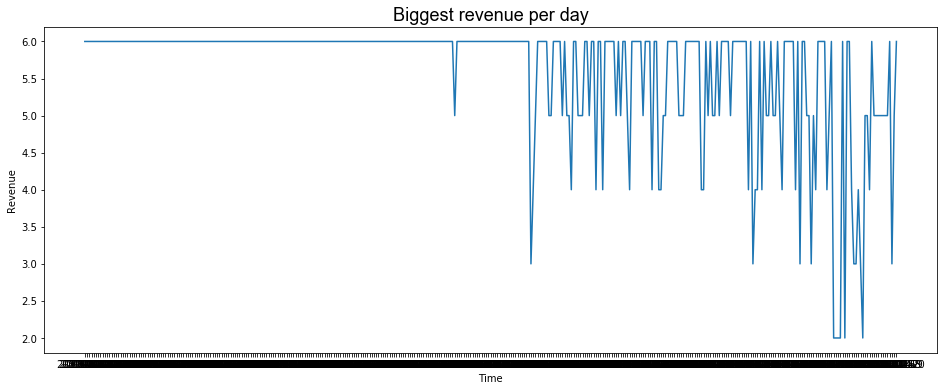

In [73]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_marburg.groupby("day")['revenue'].max()) #plotting the rides with the biggest revneues per day 
ax.set_title("Biggest revenue per day",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")

plt.show()


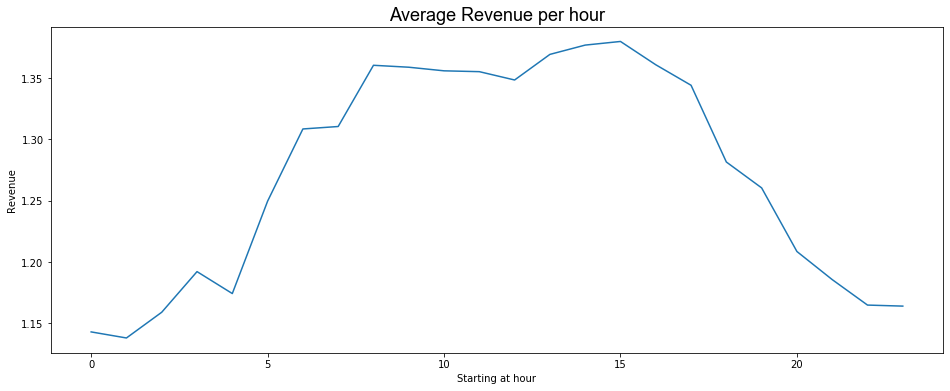

In [74]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_marburg.groupby("hour")['revenue'].mean()) #plotting the Revenue per hour
ax.set_title("Average Revenue per hour",fontsize=18, fontname="Arial")
ax.set_xlabel("Starting at hour")
ax.set_ylabel("Revenue")
        
plt.show()


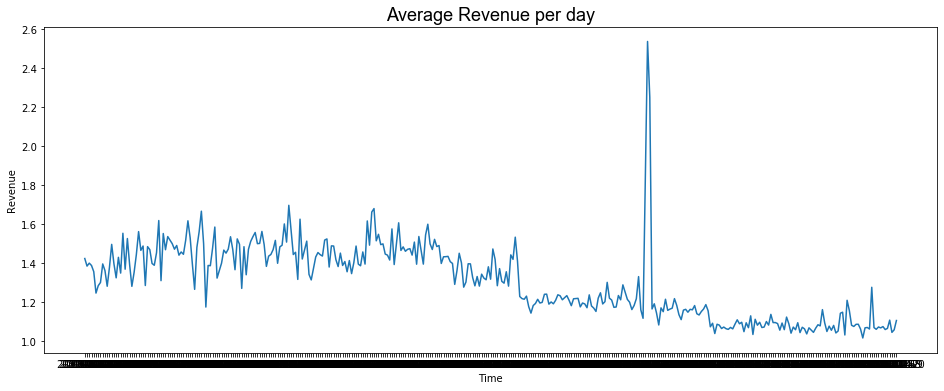

In [75]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_marburg.groupby("day")['revenue'].mean()) #plotting the Revenue per day
ax.set_title("Average Revenue per day",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.savefig('average Revenue p.d. marburg.pdf')      
plt.show()


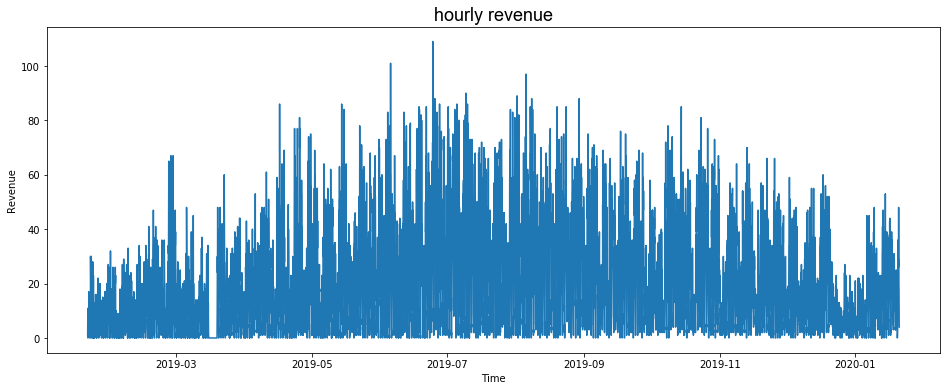

In [76]:
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
rev_duisburg = duisburg.sort_values(['datetime'])
rev_duisburg['revenue'] = rev_duisburg['trip_duration_mins']/30
rev_duisburg['revenue'] = rev_duisburg['revenue']+0.999 #because you pay the bike per 30 min rounded up (sehr ugly,möglicherweise falsch,aber weiß nicht wie mans besser macht)
rev_duisburg['revenue'] = rev_duisburg['revenue'] - rev_duisburg['revenue']%1

fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_duisburg.resample('h')['revenue'].sum()) #plotting the Revenue per hour
ax.set_title("hourly revenue",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")

plt.show()

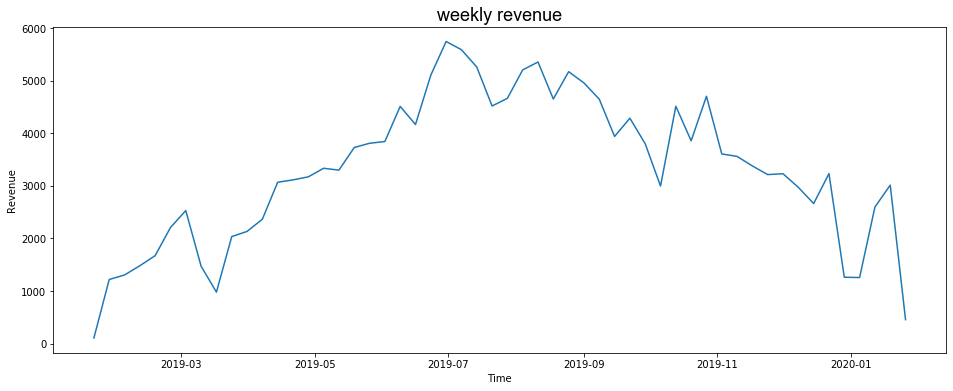

In [77]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_duisburg.resample('w')['revenue'].sum()) #plotting the Revenue per week
ax.set_title("weekly revenue",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.savefig('weekly revenue Duisburg.pdf')
plt.show()


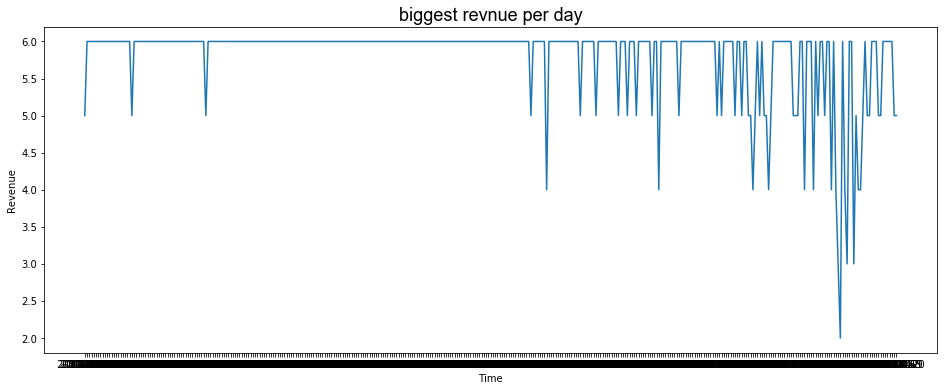

In [78]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_duisburg.groupby("day")['revenue'].max()) #plotting the rides with the biggest revneues per day
ax.set_title("biggest revnue per day",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")

plt.show()

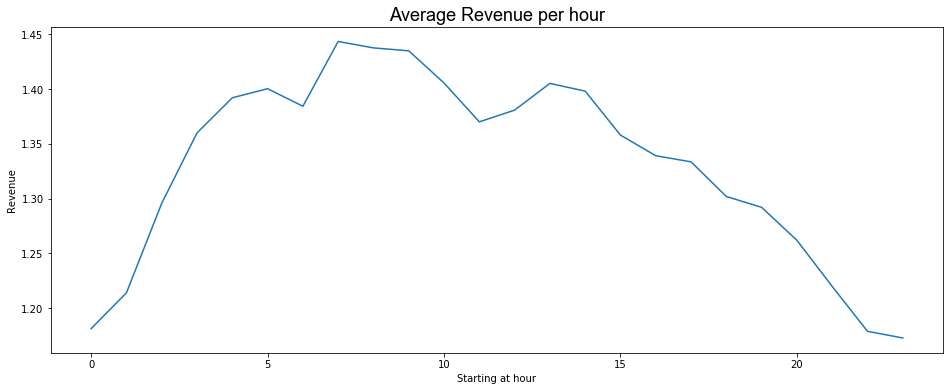

In [79]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_duisburg.groupby("hour")['revenue'].mean()) #plotting the Revenue per hour
ax.set_title("Average Revenue per hour",fontsize=18, fontname="Arial")
ax.set_xlabel("Starting at hour")
ax.set_ylabel("Revenue")
        
plt.show()

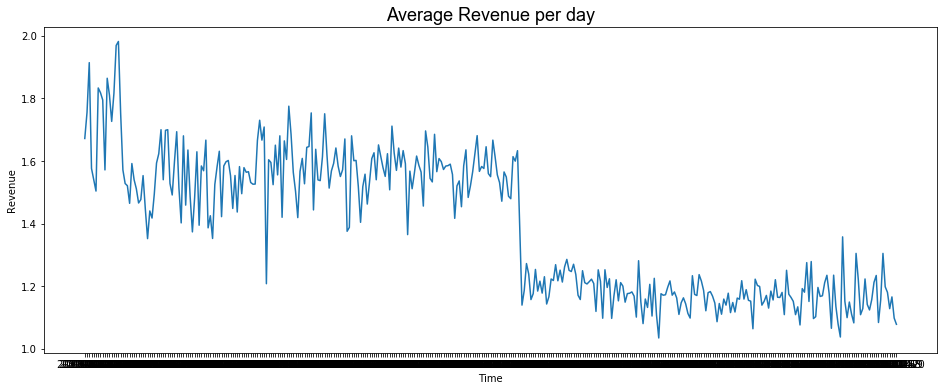

In [80]:
fig,ax = plt.subplots(figsize=(16,6))
ax.plot(rev_duisburg.groupby("day")['revenue'].mean()) #plotting the Revenue per day
ax.set_title("Average Revenue per day",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")

plt.savefig('Average revenue p.d. Duisburg.pdf')        
plt.show()


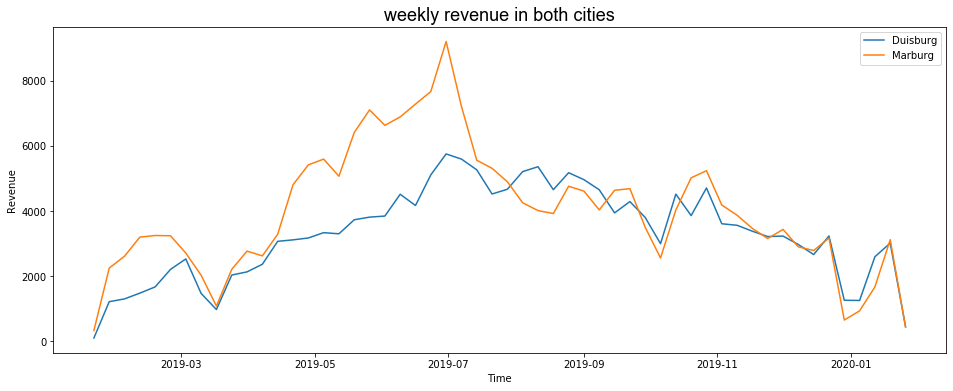

In [81]:
fig,ax = plt.subplots(figsize=(16,6))

ax.plot(rev_duisburg.resample('w')['revenue'].sum())
ax.plot(rev_marburg.resample('w')['revenue'].sum())      #plotting the Revenue per hour
ax.set_title("weekly revenue in both cities",fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
ax.legend(["Duisburg", "Marburg"])
plt.savefig('weekly_revenue_both.pdf')
plt.show()
